## Global Macro Dashboard

An overview of some important indicators of the global economy's health.

### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import quandl

import pandas_datareader.data as web
import xlrd as xls
import datetime
import missingno as msno

import os
import sys
import shutil
from pathlib import Path

from IPython.core.display import HTML

%matplotlib inline
plt.close('all')

import nbconvert
#html_css_files = ['https://cdn.jupyter.org/notebook/5.1.0/style/style.min.css']

quandl_token = 'e4FyZJfz6ukboUWG4Pm_' # hide?

In [3]:
# Setting dates for plotting
# set now to current time and date
now = datetime.datetime.now()
# set a start date in the past
start = datetime.datetime(2008, 1, 1)
# other start/end options: 
# start = '20080101'
# end = ''
today = datetime.datetime(now.year, now.month, now.day)

**Refactor code:**
- after library import have one section for raw data download; save raw data as CSVs
- add try/except in case download / API fails - have fallback to old CSV 
- next section: clean raw data, then save cleaned data as CSVs
- use cleaned CSV files to do analysis, plot etc

## Growth and Liquidity

### 1. Growth

#### GDP now

### 2. Liquidity drivers

### 3. Inflation

### 10y breakevens and 5y5y forward

In [4]:
# load from FRED API & save copy locally to CSV file
try:
    US_infl_exp_download = web.DataReader(['T10YIE','T5YIFR'], 'fred')
    US_infl_exp_download.to_csv('data/US_infl_exp.csv')
except:
    print("Problem with data download") 

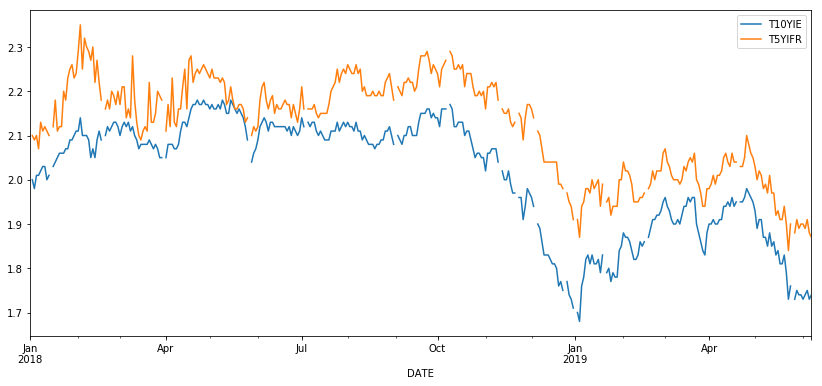

In [5]:
start = '20180101'
US_infl_exp_download.loc[start:].plot(figsize=(14, 6))
plt.show();

### US Treasury bond yields

#### Load data US treasury bond yields

In [6]:
# load from Quandl API & save copy locally to CSV file
try:
    UST_download = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)
    UST_download.to_csv("data/US_treasury_yields.csv")
except:
    print("Problem with Quandl API")

In [7]:
# load CSV into pandas DF and replace index column with date column
US_treasury_yields = pd.read_csv("data/US_treasury_yields.csv", parse_dates=['Date'])
US_treasury_yields.set_index(['Date'], drop=True, inplace=True)

#### Load US data on GDP, inflation etc from FRED

In [8]:
US_GDP = web.DataReader('GDP', 'fred')
US_GDP.to_csv("data/US_GDP.csv")
US_inflation = web.DataReader(['CPIAUCSL', 'CPILFESL'], 'fred')
US_inflation.to_csv("data/US_inflation.csv")

# FRED also has Treasury yield data available, but there seem to be more missing
# values compared to quandl, so using Quandl as above
# UST_3m_FRED = web.DataReader(['T10Y3MM'], 'fred', start, end)
# UST_2y_FRED = web.DataReader(['T10Y2Y'], 'fred', start, end)

#### VIX

In [9]:
VIX_raw = web.DataReader('VIXCLS', 'fred')
VIX_raw.to_csv("data/VIX.csv")

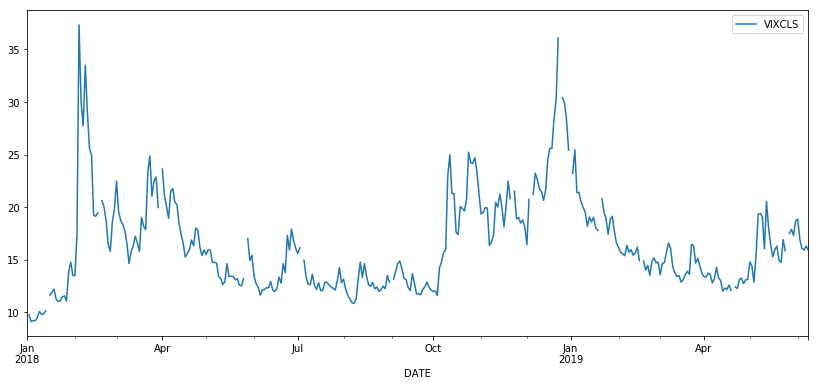

In [10]:
start = '20180101'
VIX_raw.loc[start:].plot(figsize=(14, 6))
plt.show();

#### Load data for copper / gold ratio from Quandl

In [11]:
# load from Quandl API & save copy locally to CSV file
try:
    copper_download = quandl.get("CHRIS/CME_HG2", authtoken=quandl_token)
    gold_download = quandl.get("CHRIS/CME_GC2", authtoken=quandl_token)
    copper_download.to_csv("data/copper_2nd.csv")
    gold_download.to_csv("data/gold_2nd.csv")
except:
    print("Problem with Quandl API")

In [12]:
# load CSV into pandas DF
copper_2nd_cont = pd.read_csv("data/copper_2nd.csv", parse_dates=['Date'])
gold_2nd_cont = pd.read_csv("data/gold_2nd.csv", parse_dates=['Date'])
# replace index column with datetime
copper_2nd_cont.set_index(['Date'], drop=True, inplace=True)
gold_2nd_cont.set_index(['Date'], drop=True, inplace=True)

In [13]:
copper_settle = copper_2nd_cont["Settle"]
copper_settle.tail()

Date
2019-06-04    2.6690
2019-06-05    2.6230
2019-06-06    2.6505
2019-06-07    2.6275
2019-06-10    2.6615
Name: Settle, dtype: float64

In [14]:
gold_settle = gold_2nd_cont["Settle"]
gold_settle.tail()

Date
2019-06-04    1328.7
2019-06-05    1333.6
2019-06-06    1342.7
2019-06-07    1346.1
2019-06-10    1329.3
Name: Settle, dtype: float64

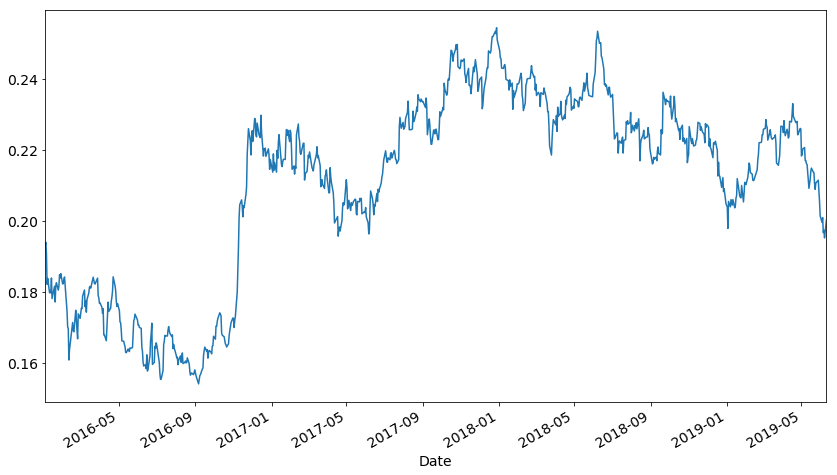

In [77]:
# set date range (specific to this ratio)
start_cu_au = datetime.datetime(2016, 1, 1)

copper_gold = pd.concat([copper_settle, gold_settle], axis=1)
column_rename = copper_gold.columns.values
column_rename[0] = 'Copper'
column_rename[1] = 'Gold'
copper_gold.columns = column_rename
cu_au_ratio = (copper_gold["Copper"] * 100 / copper_gold["Gold"])
cu_au_ratio.loc[start_cu_au:].plot(figsize=(14, 8))
plt.show()

In [78]:
copper_gold['ratio'] = copper_gold['Copper'] * 100 / copper_gold['Gold']

In [82]:
copper_gold['30d_ma'] = copper_gold['ratio'].rolling(window=20, min_periods=0).mean()

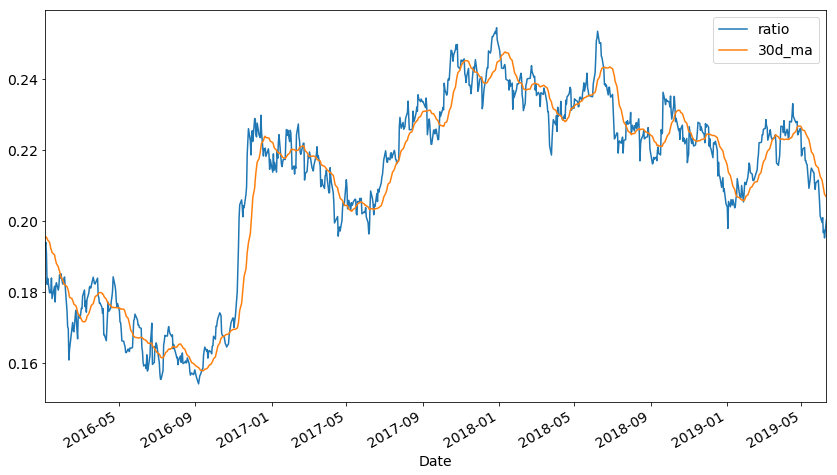

In [83]:
copper_gold[['ratio', '30d_ma']].loc[start_cu_au:].plot(figsize=(14,8))

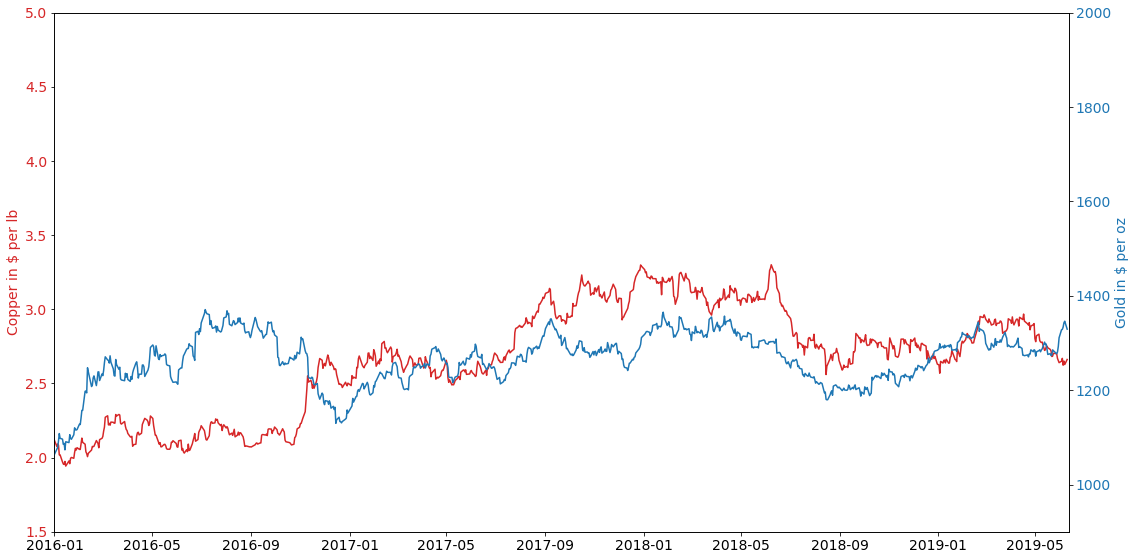

In [81]:
fig, ax1 = plt.subplots(figsize=(16,8))
color = 'tab:red'
ax1.xaxis_date()
ax1.set_xlim([start_cu_au, now])
ax1.set_ylim([1.5, 5])  ## THIS NEEDS TO BE ADAPTED / autoscaled

ax1.set_ylabel('Copper in $ per lb', color=color)
ax1.plot(copper_settle, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.set_ylim([900, 2000])  ## THIS NEEDS TO BE ADAPTED / autoscaled
color = 'tab:blue'
ax2.set_ylabel('Gold in $ per oz', color=color)
ax2.plot(gold_settle, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### GDP nowcasts

#### Atlanta data download 
check if tracking QoQ or YoY

In [17]:
# St Louis Fred nowcast
# https://fred.stlouisfed.org/series/STLENI
# US_GDP_nowcast = web.DataReader('STLENI', 'fred')

# https://www.newyorkfed.org/research/policy/nowcast
# https://fred.stlouisfed.org/series/STLENI
# Quandl nowcasts?

#### Full data

In [18]:
# right file? Check Fred
Atlanta_GDP_now_dl = pd.read_excel("https://www.frbatlanta.org/-/media/documents/cqer/researchcq/gdpnow/GDPTrackingModelDataAndForecasts.xlsx")

In [19]:
Atlanta_GDP_now_dl.tail()

,6703 11902,.excel_last,FRBCNAI@SURVEYS,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Correlation of Factors,Unnamed: 10,Unnamed: 11,0.9765090342695325
627,1812,2018-12-31,-0.01,-0.069858,2018-12-01,-0.01,-0.0698577,0,NaN,NaN,NaN,NaN,NaN
628,1901,2019-01-31,-0.25,-0.212092,2019-01-01,-0.25,-0.212092,0,NaN,NaN,NaN,NaN,NaN
629,1902,2019-02-28,-0.29,-0.486584,2019-02-01,-0.29,-0.486584,0,NaN,NaN,NaN,NaN,NaN
630,NaN,2019-03-31,NaN,NaN,2019-03-01,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
631,NaN,NaT,NaN,NaN,2019-04-01,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


#### NY Fed GDP 
tracks the annualized quarterly (“q/q”) growth rate of real GDP,not the four-quarter (“y/y”) growth rat

In [20]:
# check sources
# https://github.com/FRBNY-TimeSeriesAnalysis/Nowcasting
  
# The newestreleases for all data series are publicly available from source websites;
# real-time historical data for most series can be retrieved from the St. LouisFed’s ALFRED database.

# FRED!

In [21]:
US_treasury_yields.tail()

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
2019-06-04,2.34,2.36,2.35,2.29,2.11,1.88,1.84,1.89,2.01,2.12,2.41,2.60
2019-06-05,2.31,2.35,2.35,2.25,2.04,1.83,1.81,1.86,2.00,2.12,2.42,2.63
2019-06-06,2.32,2.35,2.33,2.22,2.02,1.88,1.85,1.88,2.01,2.12,2.42,2.62
2019-06-07,2.30,2.32,2.28,2.15,1.97,1.85,1.82,1.85,1.97,2.09,2.36,2.57
2019-06-10,2.30,2.31,2.29,2.21,2.03,1.90,1.87,1.91,2.03,2.15,2.42,2.62


#### Checking for missing values

In [22]:
#msno.bar(US_treasury_yields.sample(7295), figsize=(8, 4))
#plt.show()

#### Visualising US Treasury yields for different tenors 

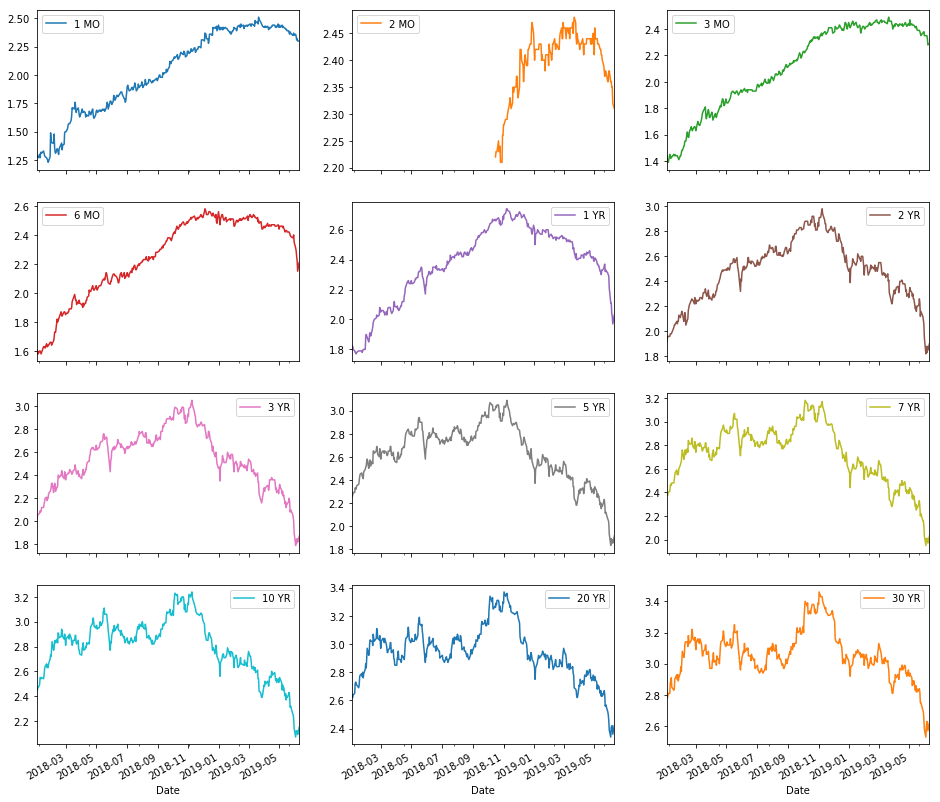

In [23]:
US_treasury_yields.loc[start:].plot(subplots=True, layout=(4,3), figsize=(16, 15))
plt.show();

#### US Treasury yield curves 

In [24]:
TSY3m2y =  US_treasury_yields['2 YR'] - US_treasury_yields['3 MO']
TSY2y10y = US_treasury_yields['10 YR'] - US_treasury_yields['2 YR']

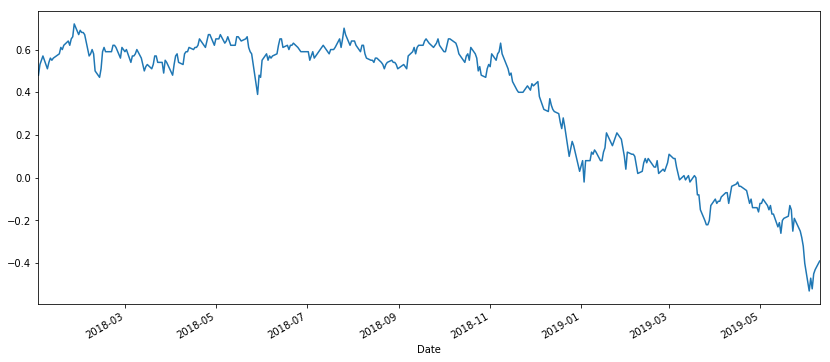

In [25]:
TSY3m2y.loc[start:].plot(figsize=(14, 6))
plt.show();

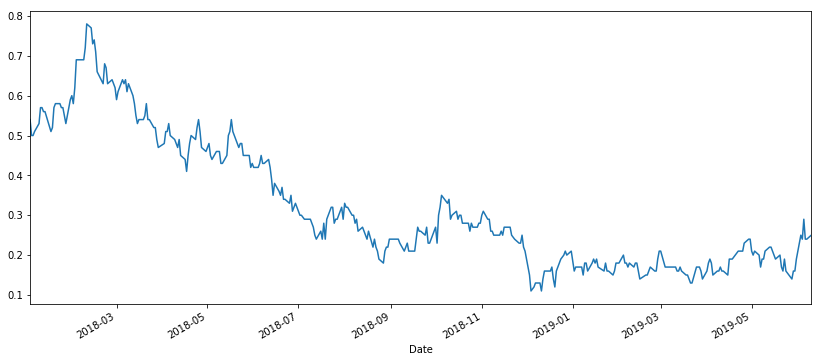

In [26]:
TSY2y10y.loc[start:].plot(figsize=(14, 6))
plt.show();

#### Plot US yield curve - today v 3m ago

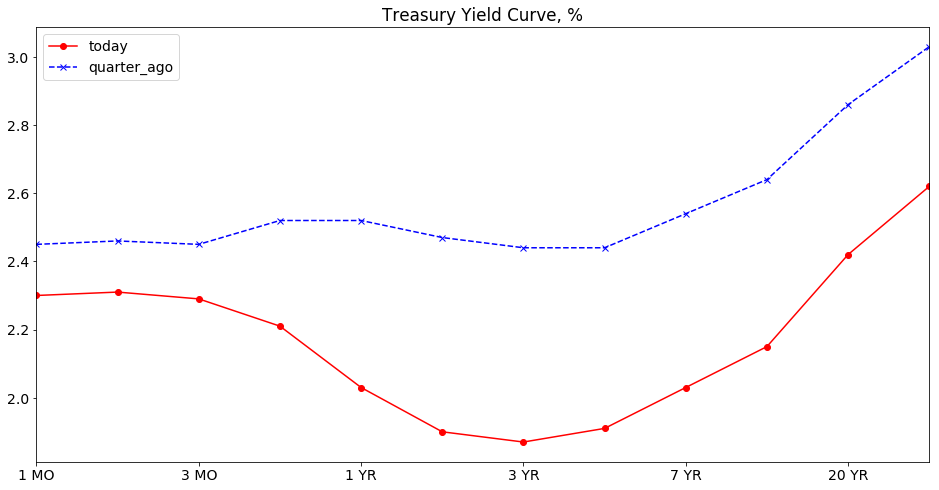

In [27]:
# WRITE PLOTTING FUNCTION SO IT CAN BE RE-USED
# + ANIMATED VERSION?
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)


US_today = US_treasury_yields.iloc[-1,:]
US_quarter_ago = US_treasury_yields.iloc[-66,:]
df = pd.concat([US_today, US_quarter_ago], axis=1)
df.columns = ['today', 'quarter_ago']

df.plot(style={'today': 'ro-', 'quarter_ago': 'bx--'}
        ,title='Treasury Yield Curve, %', figsize=(16, 8));

## German bond yields and curves

### Data sources

#### Create list of bond tenors

In [28]:
tenor = ['6 MO', '1 YR', '2 YR', '5 YR', '7 YR', '10 YR', '20 YR', '30 YR']

#### Import data from Bundesbank website

In [29]:
# creates dictionary where keys represent bond tenors and values are the URL of corresponding dataset
DE = {"DE6 MO_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3210",
      "DE1 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3211",
      "DE2 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3213",
      "DE5 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3219",
      "DE7 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3223",
      "DE10 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3229",
      "DE20 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3449",
      "DE30 YR_input": "https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WT3500"}

### Functions for loading, cleaning and concatenating data

In [30]:
def instrument_names(tenors):
    """
    creates variable names for each instrument, e.g. "DE2y" for a
    2yr German bond and also input variables that will be used in
    subsequent cleaning functions, e.g. DE2y_input
    """
    input_names = [0] * len(tenors)
    
    for i in tenors:
        index = tenors.index(i)
        if index < len(tenors):
            tenors[index] = 'DE'+ i
            input_names[index] = tenors[index] + '_input'
            
    return tenors, input_names

def bunds_clean(URL, tenor):
    """
    Loads and transforms very poorly formatted CSV files with data for each
    bond tenor from German Bundesbank and returns cleaned pandas dataframe
    """
    
    # Use pandas read_csv to download file, if that fails use wget
    try:
        DF = pd.read_csv(URL, sep=';')
    except:
        print("Problem with file download via Pandas read_csv")
        print("=================================================")
        print("Trying with wget instead - will create separate CSV files")
        filenumber = tenor[0] + 'a'
        filename = 'bund' + filenumber +'.csv'
        !wget {URL} -O "data/{filename}" -q
        PATH = "data/" + filename
        DF = pd.read_csv(PATH, sep=';')

    assert type(tenor) == str, "Tenor needs to be a string"   
    
    # remove rows without relevant data
    # the first four rows of all files need to be removed the last row 
    # needs to be removed in some files: - tenors 20 YR + 30 YR are fine
    # hence DF[4:] below, but tenors up to 10 YR contain a comment in
    # the last row, which needs to be removed, hence DF[4:-1] for all of those
    
    last_row = DF[-1:].to_string()
    if "Bemerkung" in last_row:
        DF = DF[4:-1]
    else:
        DF = DF[4:]  
        
    # rename columns to give meaningful name
    new_columns = DF.columns.values
    new_columns[0] = 'DATE'
    new_columns[1] = tenor 
    DF.columns = new_columns 
    
    # assign last column to variable 'dropcolumn'
    dropcolumn = DF.columns[2]
    
    # use dropcolumn to remove rows that have missing values (indicated by
    # string in German instead of NaN)
    DF = DF[DF[dropcolumn] != 'Kein Wert vorhanden']
    
    # now remove last column 
    DF = DF.drop([dropcolumn], axis=1)
    
    # reset dataframe index to 0 - was not the case because removed rows earlier
    DF.reset_index(drop=True, inplace=True)
    
    # replace German comma (,) with dot in RATE column
    DF[tenor] = [x.replace(',', '.') for x in DF[tenor]]
    
    # convert RATE column values from string to float
    DF[tenor] = DF[tenor].astype('float')
    
    # convert DATE column values from string to datetime
    DF['DATE'] = pd.to_datetime(DF['DATE'])
    
    # replace dataframe index column with DATE column
    DF.set_index(['DATE'], drop=True, inplace=True)
    
    return DF

def clean_and_join(input_name, tenor):
    """
    Calls bunds_clean function for each input file and concatenates 
    cleaned output into one pandas dataframe, which is returned
    """
    combined = pd.DataFrame() 
    
    for i in range(len(tenor)):
        result = bunds_clean(DE[input_name[i]], tenor[i])
        combined = pd.concat([combined, result], axis=1)
        
    return combined

In [31]:
results = instrument_names(tenor[:])
instruments = results[0]
input_name = results[1]

DE_bond_yields = clean_and_join(input_name, tenor)

DE_bond_yields.to_csv("data/DE_bond_yields.csv")

In [32]:
DE_bond_yields.tail()

,6 MO,1 YR,2 YR,5 YR,7 YR,10 YR,20 YR,30 YR
DATE,,,,,,,,
2019-06-04,-0.60,-0.63,-0.67,-0.59,-0.44,-0.21,0.28,0.48
2019-06-05,-0.60,-0.63,-0.67,-0.59,-0.44,-0.21,0.28,0.48
2019-06-06,-0.61,-0.64,-0.69,-0.62,-0.47,-0.23,0.26,0.47
2019-06-07,-0.59,-0.62,-0.66,-0.59,-0.45,-0.23,0.24,0.44
2019-06-11,-0.60,-0.63,-0.68,-0.60,-0.45,-0.22,0.26,0.46


#### Checking for missing data

In [33]:
#msno.bar(DE_bond_yields.sample(5473), figsize=(8, 3))
#plt.show()

#### Visualising German bond yields for different tenors 

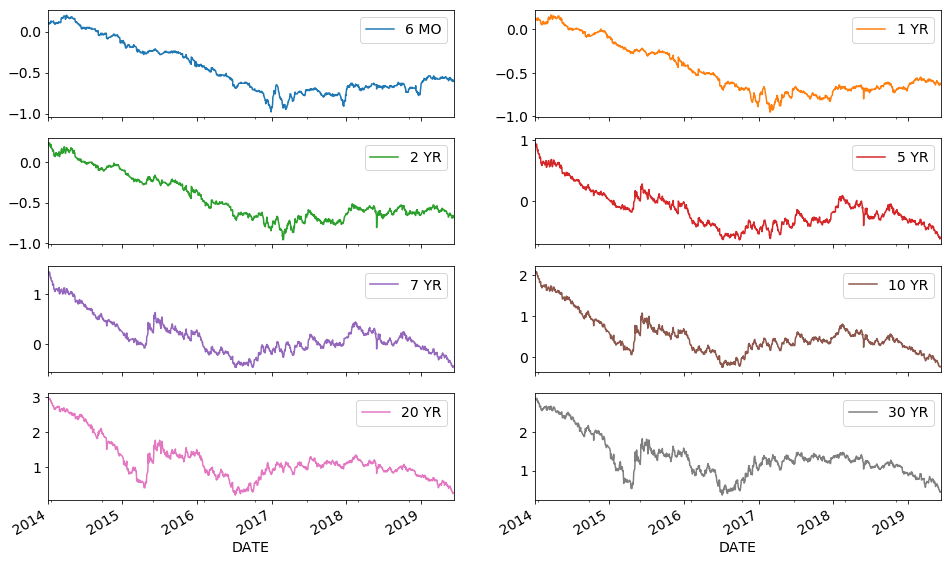

In [34]:
start = '20140101'
end = today
DE_bond_yields.loc[start:].plot(subplots=True, layout=(4,2), figsize=(16, 10))
plt.show();

#### German yield curves

In [35]:
# check if correct
DE2y10y = DE_bond_yields['10 YR'] - DE_bond_yields['2 YR']

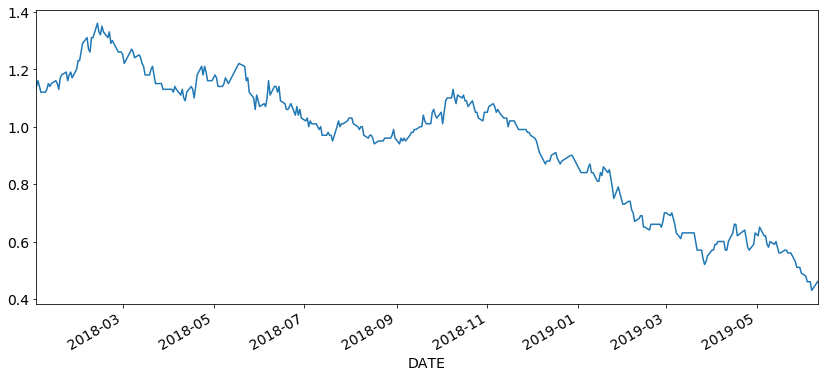

In [36]:
start = '20180101'
DE2y10y.loc[start:].plot(figsize=(14, 6))
plt.show();

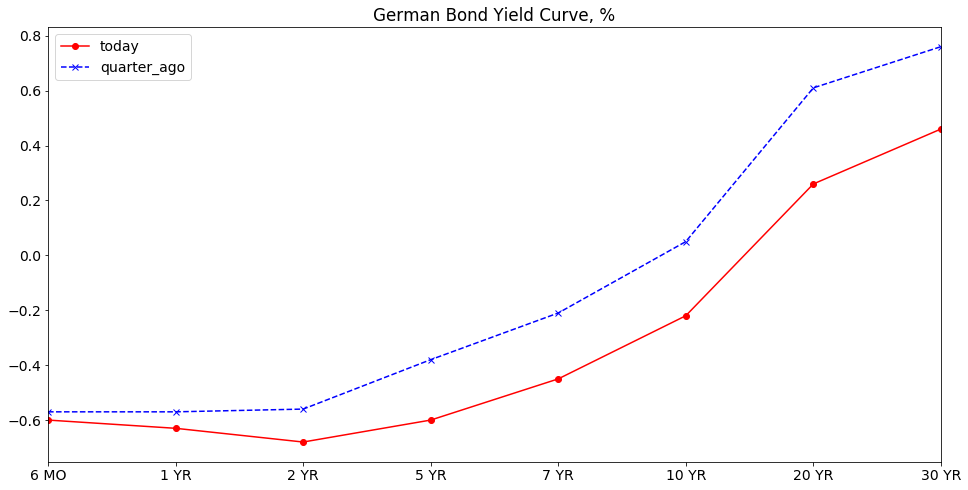

In [37]:
DE_today = DE_bond_yields.iloc[-1,:]
DE_quarter_ago = DE_bond_yields.iloc[-63,:]
df = pd.concat([DE_today, DE_quarter_ago], axis=1)
df.columns = ['today', 'quarter_ago']

df.plot(style={'today': 'ro-', 'quarter_ago': 'bx--'}
        ,title='German Bond Yield Curve, %', figsize=(16, 8));

In [38]:
# WRITE FUNCTION FOR THIS (and all other data sets)

DE_curve_today = DE_bond_yields.iloc[-1:]
DE_curve_month_ago = DE_bond_yields.iloc[-21:-20]
DE_curve_3month_ago = DE_bond_yields.iloc[-63:-62]
DE_curve_6month_ago = DE_bond_yields.iloc[-126:-125]
DE_curve_year_ago = DE_bond_yields.iloc[-252:-251]

DE_curves_combined = pd.concat([DE_curve_today, DE_curve_month_ago, DE_curve_3month_ago, DE_curve_6month_ago, DE_curve_year_ago])
DE_curves_combined

,6 MO,1 YR,2 YR,5 YR,7 YR,10 YR,20 YR,30 YR
DATE,,,,,,,,
2019-06-11,-0.60,-0.63,-0.68,-0.60,-0.45,-0.22,0.26,0.46
2019-05-13,-0.58,-0.62,-0.64,-0.48,-0.31,-0.05,0.47,0.70
2019-03-11,-0.57,-0.57,-0.56,-0.38,-0.21,0.05,0.61,0.76
2018-12-05,-0.70,-0.68,-0.66,-0.31,-0.05,0.27,0.79,0.99
2018-06-11,-0.67,-0.70,-0.64,-0.16,0.15,0.50,1.03,1.21


#### Plot German yield curve - today v 3m ago

In [39]:
# WRITE FUNCTION FOR THIS (and all other data sets)

DE_diff_today_month_ago = DE_curves_combined.iloc[0] - DE_curves_combined.iloc[1]
DE_diff_today_3month_ago = DE_curves_combined.iloc[0] - DE_curves_combined.iloc[2]
DE_diffs_combined = pd.concat([DE_diff_today_month_ago, DE_diff_today_3month_ago], axis=1)

DE_diffs_combined = DE_diffs_combined.T
DE_diffs_combined.rename({0: "vs 1 MO", 1: "vs 3 MO"}, axis='index', inplace=True)
DE_diffs_combined

,6 MO,1 YR,2 YR,5 YR,7 YR,10 YR,20 YR,30 YR
vs 1 MO,-0.02,-0.01,-0.04,-0.12,-0.14,-0.17,-0.21,-0.24
vs 3 MO,-0.03,-0.06,-0.12,-0.22,-0.24,-0.27,-0.35,-0.30


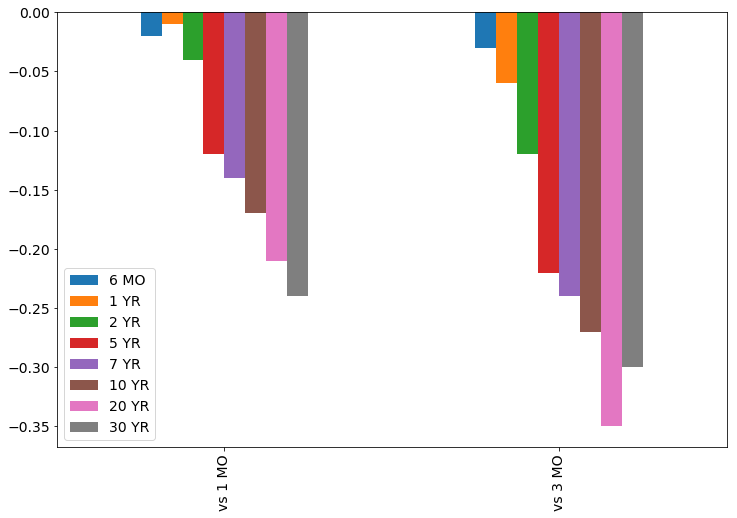

In [40]:
#DE_diffs_combined = pd.DataFrame(data=DE_diffs_combined)
DE_diffs_combined.plot.bar(figsize=(12,8))
plt.show()

## Australian yields

In [41]:
# OZ = pd.read_csv(URL_OZ, encoding='latin-1')  # because of ñ !!!
# big lesson - look at the file before! # show error!!
# conclusion: take excel format - easier here!

# Download via pandas is error-prone, hence try/except procedure which
# uses alternative python command line !wget

URL_OZ = "https://www.rba.gov.au/statistics/tables/xls/f02d.xls"

try:
    OZ_download = pd.read_excel(URL_OZ2, parse_dates=True)
    OZ_download.to_excel("data/OZ.xls")
except:
    print("Problem with download via Pandas read_excel from RBA website")
    print("============================================================")
    print("Trying with wget downloader instead")
    print("============================================================")
    !wget {URL_OZ} -O "data/OZ.xls" -q

# additonal problems may occur i.e. the download may result in an empty file
# if that happens, we take the most recent back-up file

file = Path() / 'data/OZ.xls'  
size = file.stat().st_size

# REPLACE WITH DATE criterion instead of size == 0 (!!)
if size == 0:
    OZ_yields = pd.read_excel("data/OZ_backup.xls", parse_dates=True)
else:
    OZ_yields = pd.read_excel("data/OZ.xls", parse_dates=True)
    shutil.copy("data/OZ.xls", "data/OZ_backup.xls")

Problem with download via Pandas read_excel from RBA website
Trying with wget downloader instead


In [42]:
OZ_yields = OZ_yields[10:]

In [43]:
OZ_yields.rename(columns={OZ_yields.columns[0]: "DATE"}, inplace=True)
OZ_yields.set_index(['DATE'], drop=True, inplace=True)

In [44]:
OZ_yields_cl = OZ_yields.rename(columns={OZ_yields.columns[0]: "2 YR", \
                 OZ_yields.columns[1]: "3 YR", OZ_yields.columns[2]: "5 YR", \
                 OZ_yields.columns[3]: "10 YR"})

In [45]:
# remove unneeded columns 
OZ_yields = OZ_yields_cl.drop(OZ_yields.columns[[4, 5, 6, 7]], axis=1)

In [46]:
OZ_yields.tail()

,2 YR,3 YR,5 YR,10 YR
DATE,,,,
2019-03-22,1.505,1.435,1.49,1.835
2019-03-25,1.475,1.405,1.45,1.78
2019-03-26,1.52,1.44,1.485,1.825
2019-03-27,1.49,1.4,1.435,1.775
2019-03-28,1.465,1.375,1.405,1.725


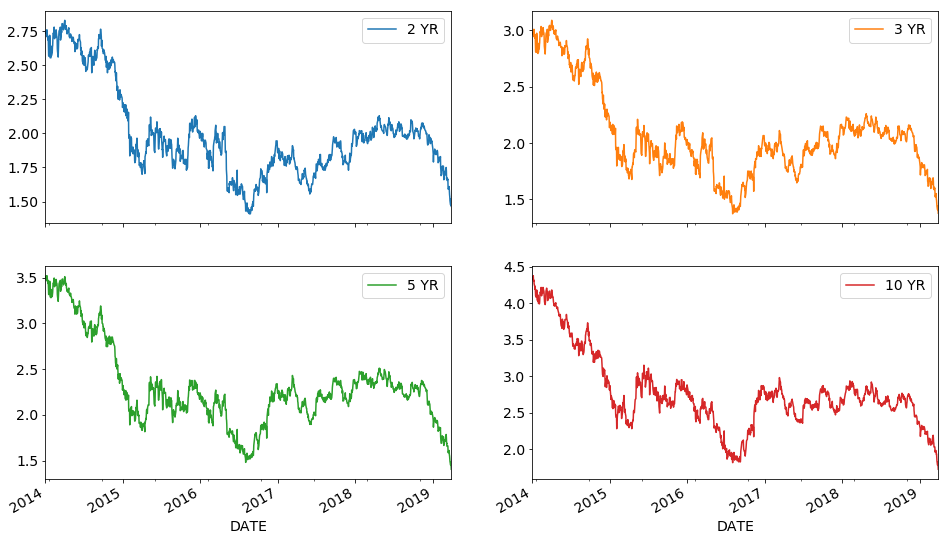

In [47]:
start = '20140101'
end = today
OZ_yields.loc[start:].plot(subplots=True, layout=(4,2), figsize=(16, 20))
plt.show();

#### Plot Australian yield curve - today v 3m ago

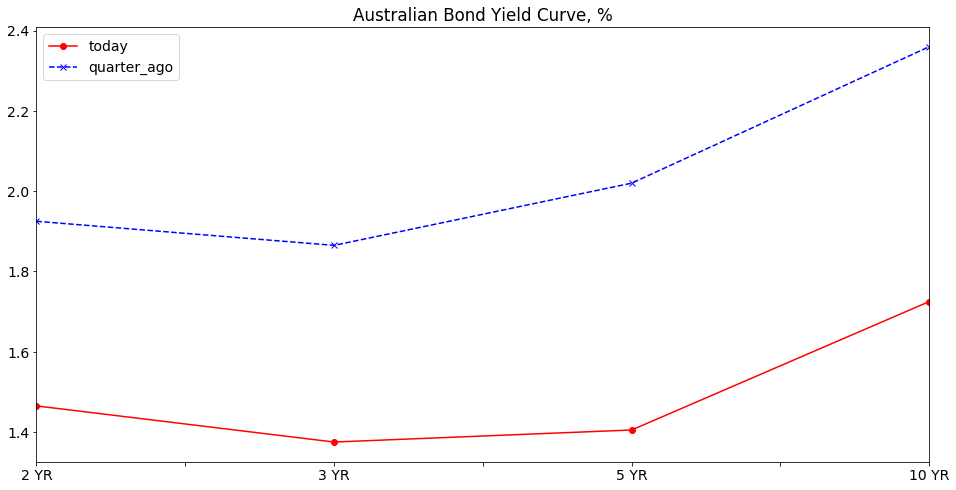

In [48]:
OZ_today = OZ_yields.iloc[-1,:]
OZ_quarter_ago = OZ_yields.iloc[-63,:]
df = pd.concat([OZ_today, OZ_quarter_ago], axis=1)
df.columns = ['today', 'quarter_ago']

df.plot(style={'today': 'ro-', 'quarter_ago': 'bx--'}
        ,title='Australian Bond Yield Curve, %', figsize=(16, 8));

## Russian yields

In [49]:
# needs scraping

#https://www.cbr.ru/eng/hd_base/zcyc_params/

## Canada

In [50]:
# . "https://www.bankofcanada.ca/valet/observations/FXCADUSD/csv"
# with Get?


## Japan

In [51]:
# load long-term history and most recent data points 
japan_hist = pd.read_csv("https://www.mof.go.jp/english/jgbs/reference/interest_rate/historical/jgbcme_all.csv",\
                         header=1, parse_dates=['Date'])
japan_current = pd.read_csv("https://www.mof.go.jp/english/jgbs/reference/interest_rate/jgbcme.csv", \
                            header=1, parse_dates=['Date'])

In [52]:
# now likely not needed that parse_dates=['column'] works
# convert date format from separator "/" to "-"
#japan_hist["Date"] = pd.to_datetime(japan_hist["Date"]).dt.strftime('%Y-%m-%d')
#japan_current["Date"] = pd.to_datetime(japan_current["Date"]).dt.strftime('%Y-%m-%d')

In [53]:
# convert those columns in japan_hist that are objects to floats
for col in japan_hist.columns[1:]:
    japan_hist[col] = pd.to_numeric(japan_hist[col], errors='coerce')

In [54]:
# replace index column with date column
japan_hist.set_index(['Date'], drop=True, inplace=True)
japan_current.set_index(['Date'], drop=True, inplace=True)

In [55]:
combined_JGB = pd.concat([japan_hist, japan_current])

In [56]:
# save a copy locally as a CSV
combined_JGB.to_csv("data/JGB_yields.csv")

In [57]:
# check data type of index - it should be datetime
# however parse_dates did not work above in read_csv, so it still is an object
combined_JGB.index

DatetimeIndex(['1974-09-24', '1974-09-25', '1974-09-26', '1974-09-27',
               '1974-09-28', '1974-09-30', '1974-10-01', '1974-10-02',
               '1974-10-03', '1974-10-04',
               ...
               '2019-05-28', '2019-05-29', '2019-05-30', '2019-05-31',
               '2019-06-03', '2019-06-04', '2019-06-05', '2019-06-06',
               '2019-06-07', '2019-06-10'],
              dtype='datetime64[ns]', name='Date', length=11525, freq=None)

In [58]:
# now likely not needed that parse_dates=['column'] works
# convert index to datetime
#combined_JGB.index = pd.to_datetime(combined_JGB.index)

In [59]:
combined_JGB.tail(10)

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,25Y,30Y,40Y
Date,,,,,,,,,,,,,,,
2019-05-28,-0.154,-0.162,-0.173,-0.180,-0.179,-0.177,-0.174,-0.150,-0.110,-0.066,0.139,0.327,0.415,0.493,0.542
2019-05-29,-0.166,-0.173,-0.189,-0.195,-0.196,-0.195,-0.197,-0.172,-0.133,-0.089,0.118,0.307,0.394,0.470,0.518
2019-05-30,-0.157,-0.169,-0.180,-0.185,-0.186,-0.187,-0.186,-0.162,-0.123,-0.077,0.131,0.318,0.408,0.483,0.528
2019-05-31,-0.158,-0.179,-0.193,-0.199,-0.201,-0.202,-0.201,-0.177,-0.138,-0.092,0.113,0.298,0.384,0.456,0.503
2019-06-03,-0.161,-0.180,-0.194,-0.200,-0.201,-0.201,-0.197,-0.173,-0.133,-0.088,0.123,0.308,0.395,0.465,0.513
2019-06-04,-0.162,-0.186,-0.204,-0.210,-0.211,-0.213,-0.210,-0.183,-0.142,-0.097,0.110,0.293,0.379,0.445,0.492
2019-06-05,-0.183,-0.221,-0.243,-0.249,-0.250,-0.247,-0.237,-0.211,-0.168,-0.123,0.086,0.268,0.351,0.422,0.465
2019-06-06,-0.183,-0.207,-0.227,-0.240,-0.240,-0.238,-0.232,-0.209,-0.163,-0.116,0.091,0.268,0.345,0.412,0.456
2019-06-07,-0.173,-0.197,-0.221,-0.235,-0.229,-0.231,-0.222,-0.202,-0.157,-0.112,0.097,0.268,0.345,0.403,0.444


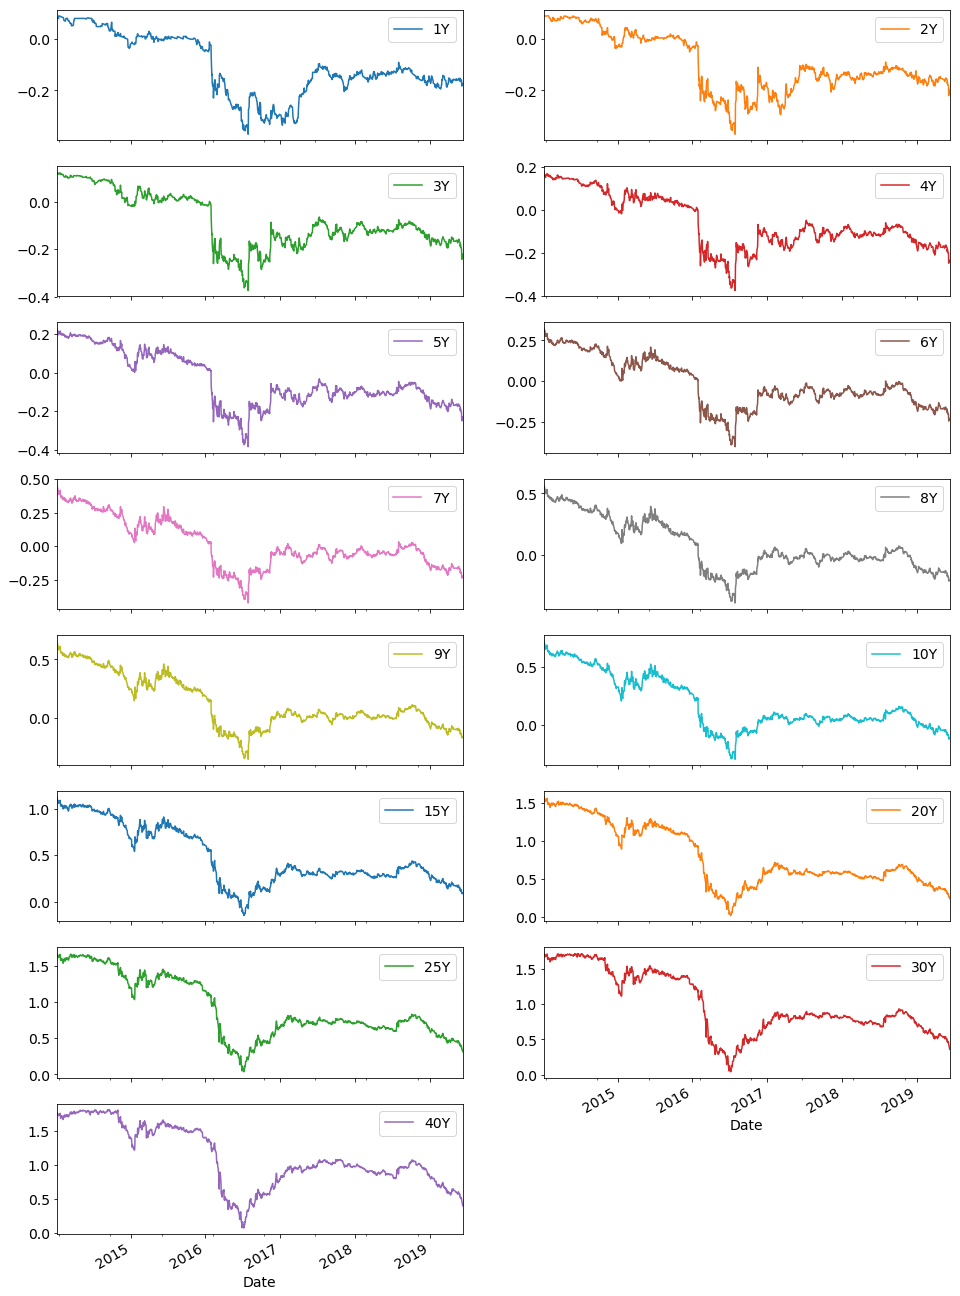

In [60]:
start = '20140101'
#start = datetime.datetime(2008, 1, 1)
end = today
combined_JGB[start:].plot(subplots=True, layout=(8,2), figsize=(16, 25))
plt.show();

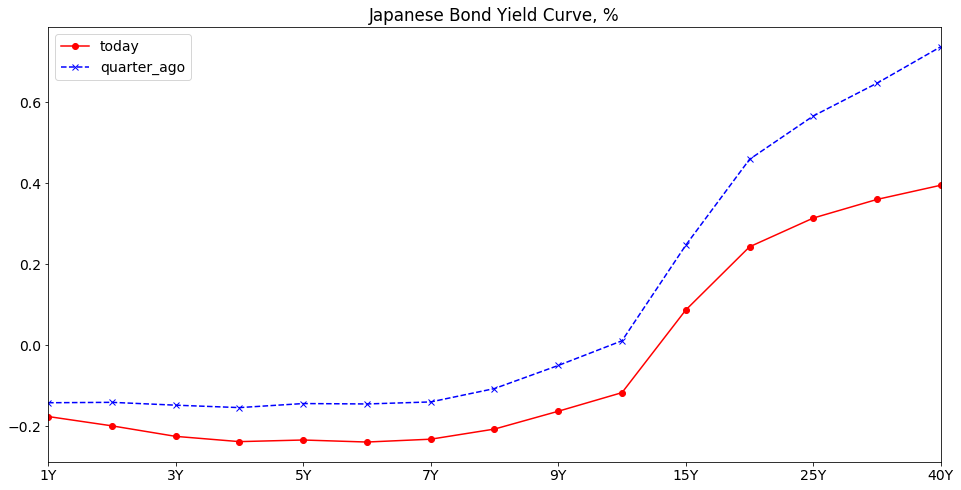

In [61]:
JGB_today = combined_JGB.iloc[-1,:]
JGB_quarter_ago = combined_JGB.iloc[-63,:]
df = pd.concat([JGB_today, JGB_quarter_ago], axis=1)
df.columns = ['today', 'quarter_ago']

df.plot(style={'today': 'ro-', 'quarter_ago': 'bx--'}
        ,title='Japanese Bond Yield Curve, %', figsize=(16, 8));

#### Todo

In [62]:
# Write function for DE yield curves

#def generate_yieldcurves:

#DE_yield_curve = pd.DataFrame()
#DE_yield_curve['2y10y'] =  DE_bond_yields.apply(lambda x: x['10y'] - x['2y'], axis=1)

#def clean_and_join(input_name, tenor):
#    """
#    """
#    combined = pd.DataFrame() 
#    for i in range(len(tenor)):
#        result = bunds_clean(DE[input_name[i]], tenor[i])
#        combined = pd.concat([combined, result], axis=1)
#    return combined